## Load the data in pickle file 

In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


### Load the real observations

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [5]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


/tmp/ipykernel_31111/4168053547.py:13: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_31111/4168053547.py:15: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [6]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])

## Now we can use the data to run some simple regression models

In [7]:
time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = np.zeros((len(dic_forced_response_ssp585.keys()), time_period))
x_predictor = np.zeros((len(dic_forced_response_ssp585.keys()), time_period, grid_lat_size, grid_lat_size))

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)        

In [9]:
# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

In [10]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]

### Define deep autoencoder with Pytorch

In [11]:
import torch.nn as nn
torch.set_default_dtype(torch.float64)

# Define the Deep Autoencoder architecture
class DeepAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            # nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Huber loss function
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
        self.loss = nn.SmoothL1Loss(reduction='mean')

    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        condition = (residual < self.delta).float()
        loss = condition * 0.5 * residual ** 2 + (1 - condition) * (self.delta * residual - 0.5 * self.delta ** 2)
        return torch.mean(loss)

In [12]:
# the input is a single value for each grid cell
def autoencoder_training(x,y,input_size, hidden_size,output_size,num_epochs=100):

    # input_size = (1, number of grid cells)
    # hidden size = arbitrary low number (1000?)
    
    # Create the Deep Autoencoder model
    model = DeepAutoencoder(input_size, hidden_size, output_size)
    
    # Define least squares loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


    for epoch in range(num_epochs):
        
        inputs = x.reshape(input_size).detach()
    
        # Forward pass
        beta = model(inputs)
    
        # Compute least squares loss
        loss = criterion(y, torch.matmul(x,beta)) + torch.norm(beta,p=2)**2
        # loss = criterion(y, beta)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print progress
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


    return model,beta

In [28]:
def autoencoder_training_test(x,y,batch_number,input_size, hidden_size,output_size,num_epochs=100):

    # input_size = (1, number of grid cells)
    # hidden size = arbitrary low number (1000?)
    
    # Create the Deep Autoencoder model
    model = DeepAutoencoder(input_size, hidden_size, output_size)
    
    # Define least squares loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = HuberLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


    for epoch in range(num_epochs):

        loss = torch.tensor(0.0)
        for i in range(batch_number):
            
            inputs = x[i*33:(i+1)*33,:].ravel().detach()
        
            # Forward pass
            beta = model(inputs)
        
            # Compute least squares loss
            loss += criterion(y[i*33:(i+1)*33], torch.matmul(x[i*33:(i+1)*33,:],beta)) + torch.norm(beta,p=2)**2
            # loss = criterion(y, beta)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print progress
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


    return model,beta

In [29]:
# concatenate several model runs
x_test = 0  
y_test = 0
batch_number = 0
for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    if m!= 'GISS-E2-2-G':
        batch_number += len(dic_reduced_ssp585[m].keys())
        if idx_m == 0:
            x_test = x_train[m]
            y_test = y_train[m]
        else:
            x_test = torch.cat((x_test,x_train[m]),0)
            y_test = torch.cat((y_test,y_train[m]),0)

In [30]:
# input_size = x_train[m].shape[0]*grid_lon_size*grid_lat_size
input_size = 33*grid_lon_size*grid_lat_size
hidden_size = 200
output_size = grid_lon_size*grid_lat_size

model,beta = autoencoder_training_test(x_test,y_test,batch_number,input_size, hidden_size,output_size,num_epochs=100)
# model,beta = autoencoder_training_test(x_train[m],y_train[m],len(dic_reduced_ssp585[m].keys()),input_size, hidden_size,output_size,num_epochs=100)

Epoch [1/100], Loss: 2875.1462
Epoch [11/100], Loss: 1151.8311
Epoch [21/100], Loss: 247.6666
Epoch [31/100], Loss: 57.2928
Epoch [41/100], Loss: 21.2544
Epoch [51/100], Loss: 8.7079
Epoch [61/100], Loss: 3.7883
Epoch [71/100], Loss: 1.9418
Epoch [81/100], Loss: 1.2758
Epoch [91/100], Loss: 0.9858


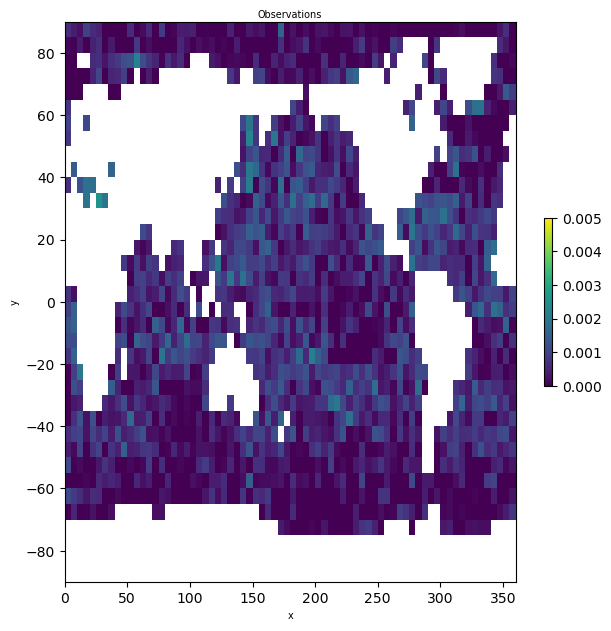

In [33]:
# define beta to plot
beta_tmp = beta.detach().clone()
beta_tmp[nans_idx] = float('nan')
beta_tmp = beta_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Observations', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.show()

In [34]:
m = 'GISS-E2-2-G'
beta = model(x_train[m][33:66,:].ravel())

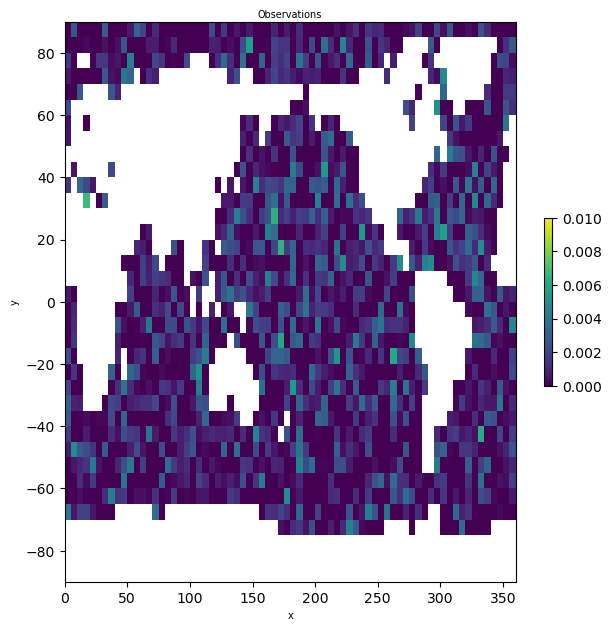

In [35]:
# define beta to plot
beta_tmp = beta.detach().clone()
beta_tmp[nans_idx] = float('nan')
beta_tmp = beta_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Observations', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.show()

# Deep Variational Autoencoder (VAE) with a a loss robust towards out-of-distribution samples

## Leave-one-out procedure

In [19]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs=500,verbose=True):

    # Data preprocessing
    x_train = {}
    y_train = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            selected_models.append(m)
            
            x_train[m] = torch.from_numpy(np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])).to(torch.float64)
            y_train[m] = torch.from_numpy(np.nan_to_num(y[m])).to(torch.float64)
        
            nans_idx = np.where(np.isnan(x[m][0,:,:].ravel()))[0]

        else:
            x_test = np.nan_to_num(x[m]).reshape(x[m].shape[0],x[m].shape[1]*x[m].shape[2])            
            y_test = np.nan_to_num(y[m])


    beta_robust = train_robust_model(x_train,y_train,vars,\
                                      lon_size,lat_size,\
                                      selected_models,alpha_,lambda_,nbEpochs,verbose)

    
    y_pred = np.dot(x_test,beta_robust)


    return beta_robust, y_pred, y_test
    # minx = np.min(y_test)
    # maxx = np.max(y_test)
    # x_tmp = np.linspace(minx,maxx,100)
    # y_tmp = x_tmp
    
    
    # fig, ax = plt.subplots()
    # ax.scatter(y_test,y_pred,label='robust')
    # ax.plot(x_tmp,y_tmp)
    # ax.set_xlabel('observations')
    # ax.set_ylabel('predictions')
    # ax.legend()
    # plt.show()
    

In [20]:
def leave_one_out_procedure(x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs=500,verbose=True):

    beta_robust = {}
    y_pred = {}
    y_test = {}
    
    for idx_m, m in enumerate(x.keys()):
        beta_robust[m], y_pred[m], y_test[m] = leave_one_out(m,x,y,vars,lon_size,lat_size,alpha_,lambda_,nbEpochs,verbose)
        print('RMSE on model ', m, ' : ', np.mean((y_pred[m] - y_test[m])**2))

    # create the function y=x
    minx = np.min(y_test[m])
    maxx = np.max(y_test[m])
    x_tmp = np.linspace(minx,maxx,100)
    y_tmp = x_tmp

    # plot the observation vs prediction accuracy
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):

        axs[idx_m].scatter(y_test[m],y_pred[m],label=m,s=0.1)
        axs[idx_m].plot(x_tmp,y_tmp)
        axs[idx_m].set_title(m)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.show()
    
    # plot the beta map for each leave-one-out run
    # plot the observation vs prediction accuracy
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_robust_tmp = beta_robust[m].detach().clone()
        beta_robust_tmp[nans_idx] = 1e5
        beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat_size,lon_size)

        axs[idx_m].set_title(m)
        im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.005)

    plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.show()
        

In [21]:
leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
              grid_lon_size,grid_lat_size,\
              alpha_,lambda_,\
              nbEpochs=1000,verbose=False)

NameError: name 'alpha_' is not defined

## All models vs Observations

In [ ]:
alpha_ = 0.5
lambda_ = 50
selected_models = list(dic_reduced_ssp585.keys())
beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
                          grid_lat_size,grid_lat_size,\
                          selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

In [ ]:
# Compute anomalies of X
x_obs = sst[131:164,:,:]
x_obs[x_obs<-1e5] = float('nan')

# Compute mean over space
y_obs = np.nanmean(x_obs[:,:,:],axis=(1,2))

# coefficient factor
beta_softmax_test = beta_robust.detach().numpy().reshape(x_obs.shape[1]*x_obs.shape[2])
beta_softmax_test[beta_softmax_test>1e3] = 0.0

y_pred_softmax = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_softmax_test)
# y_pred_reg = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_reg_test)

In [ ]:
minx = np.min(y_obs)
maxx = np.max(y_obs)
x_tmp = np.linspace(minx,maxx,100)
y_tmp = x_tmp


fig, ax = plt.subplots()
ax.scatter(y_obs,y_pred_softmax,label='robust')
ax.plot(x_tmp,y_tmp)
ax.set_xlabel('observations')
ax.set_ylabel('predictions')
ax.legend()
plt.show()